# Calibração de incerteza (*Uncertainty calibration*)

Diversos modelos de classificação binária apresentam como saída um valor contínuo entre 0 e 1. É comum encontrarmos explicações que associam esses valores a probabilidades.

Por exemplo, uma amostra cuja predição seja 0.6 seria indicada como possuindo 60% de probabilidade de pertencer à classe positiva (1). Ou então, pode ser dito que uma predição de 0.9 é mais confiável que uma de 0.6.

[Um exemplo do dia-a-dia são as previsões do tempo](https://towardsdatascience.com/introduction-to-reliability-diagrams-for-probability-calibration-ed785b3f5d44). O que significa uma probabilidade de 20% de chuva? Na prática, podemos imaginar que, se considerarmos todos os dias em que a probabilidade de chuva é predita como 20% ao longo de vários anos, de fato, choverá em 20% desses dias.

Esses valores realmente podem ter essa interpretação, mas somente se o modelo estiver devidamente **calibrado**. A calibração de um modelo está, portanto, relacionada com a concordância entre suas predições e a frequência relativa observada do evento. Se de todos os dias em que o modelo previu a probabilidade de chuva como 20%, chovesse em 40% dos dias, diríamos que o modelo está mal calibrado.

Assim, com um modelo mal calibrado, perdemos a **confiabilidade** na interpretação da sua saída como uma probabilidade. Isso não quer dizer necessariamente que esse será um modelo ruim. Se estivermos interessados apenas nas classes binárias (0 e 1), tanto faz se o modelo prevê uma amostra negativa como 0.1 ou 0.4, já que ambas serão classificadas como 0 (se o valor de corte for 0.5). Conclui-se que um modelo, mesmo mal calibrado, ainda pode apresentar boas métricas de qualidade, como acurácia.

Vamos mostrar abaixo como verificar se um modelo está calibrado gerando o **diagrama de confiabilidade** (*reliability diagram*) para suas predições. Vamos avaliar também como modelos gerados com diferentes representações (descritores 2D e *fingerprints* moleculares) e algoritmos (regressão logística e *Random Forest*) se comportam em relação à calibração. 

Também quero explorar o efeito do uso de diferentes estratégies de *splitting* na calibração do modelo. Para isso, vou usar o *dataset* [BACE (MoleculeNet)](https://moleculenet.org/datasets-1), que vem com uma coluna indicando compostos de treinamento e teste separados de acordo com o *scaffold split*. Para gerar o *random split*, vou juntar todos os dados antes de fazer o *split*. Para mais detalhes, consulte o Notebook [Data splits - selecionando um conjunto de teste](https://github.com/rflameiro/Python_e_Quiminformatica/blob/main/Quiminformatica/Data%20splits%20-%20selecionando%20um%20conjunto%20de%20teste.ipynb).

Finalmente, vou apresentar algumas situações que prejudicam a calibração das incertezas dos modelos.

## Um exemplo simples de diagrama de confiabilidade

Vou descrever passo a passo como é gerado o diagrama, e, em seguida, mostrar a implementação do `scikit-learn`.

Tendo separado seu conjunto de dados em treinamento e teste, e treinado o modelo no conjunto de treinamento, gere as predições para o conjunto de teste. Suponha que os resultados tenham sido os seguintes:

```
y_true = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1])  # valores verdadeiros das classes
y_pred = np.array([0.1, 0.2, 0.3, 0.4, 0.65, 0.7, 0.8, 0.9, 1.0])  # predições
```

Em seguida, separamos os valores das predições em blocos (*bins*).

No exemplo, vamos considerar 3 blocos, de forma que o bloco 1 contém as predições no intervalo \[0, 0.333), o bloco 2 no intervalo \[0.333, 0.667), o bloco 3, no intervalo \[0.667, 1.0). Mais blocos podem ser usados quando há mais dados disponíveis. Alternativamente, [quantis](https://pt.wikipedia.org/wiki/Quantil) podem ser usados. No exemplo, esses seriam os blocos (e as classes correspondentes): 

- Bloco 1: [0.1, 0.2, 0.3] --> [0, 0, 0]
- Bloco 2: [0.4, 0.65] --> [0, 1]
- Bloco 3: [0.7, 0.8, 0.9, 1.0] --> [1, 1, 1, 1]

Agora, comparamos a média das predições em cada bloco com as frequências relativas dos exemplos positivos. Em termos mais concretos, vamos verificar se as predições do Bloco 1, cuja média no nosso exemplo é de 0.2, contém de fato cerca de 20% de amostras positivas (dessa forma, confirmamos que as predições nesse intervalo possuem, de fato, cerca de 20% de probabilidade de pertencerem à classe 1).

Após fazer isso para todas as classes, geramos um gráfico de dispersão indicando os valores observados e os esperados para um modelo perfeitamente calibrado (diagonal).

Veja como fazer isso no `scikit-learn`:

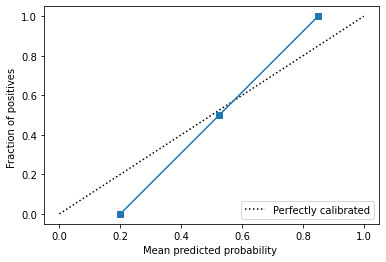

In [4]:
import numpy as np
from sklearn.calibration import calibration_curve, CalibrationDisplay

y_true = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1])
y_pred = np.array([0.1, 0.2, 0.3, 0.4, 0.65, 0.7, 0.8, 0.9, 1.0])

prob_true, prob_pred = calibration_curve(y_true, y_pred, n_bins=3)

disp = CalibrationDisplay(prob_true, prob_pred, y_pred)
disp.plot();

Vemos que as predições não estão perfeitamente calibradas, mas estão próximas da diagonal.

Vamos ver um exemplo com mais dados:

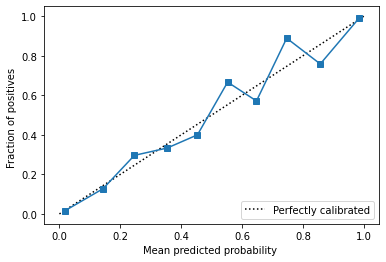

In [15]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve, CalibrationDisplay

X, y = make_classification(n_samples=5000, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

clf = LogisticRegression(random_state=0)
clf.fit(X_train, y_train)

y_prob = clf.predict_proba(X_test)[:, 1]

prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10)

disp = CalibrationDisplay(prob_true, prob_pred, y_prob)
disp.plot();

## Avaliando o efeitos das representações, algoritmos e *splitting* na calibração

In [67]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from rdkit import Chem 
from rdkit.Chem import AllChem, Descriptors
from rdkit.Chem import rdFingerprintGenerator
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import calibration_curve, CalibrationDisplay
from sklearn.preprocessing import StandardScaler

In [21]:
df = pd.read_csv("../datasets/bace.csv")
df.head()

,mol,CID,Class,Model,pIC50,MW,AlogP,HBA,HBD,RB,...,PEOE6 (PEOE6),PEOE7 (PEOE7),PEOE8 (PEOE8),PEOE9 (PEOE9),PEOE10 (PEOE10),PEOE11 (PEOE11),PEOE12 (PEOE12),PEOE13 (PEOE13),PEOE14 (PEOE14),canvasUID
0,O1CC[C@@H](NC(=O)[C@@H](Cc2cc3cc(ccc3nc2N)-c2c...,BACE_1,1,Train,9.154901,431.56979,4.4014,3,2,5,...,53.205711,78.640335,226.85541,107.43491,37.133846,0.000000,7.980170,0.0,0.000000,1
1,Fc1cc(cc(F)c1)C[C@H](NC(=O)[C@@H](N1CC[C@](NC(...,BACE_2,1,Train,8.853872,657.81073,2.6412,5,4,16,...,73.817162,47.171600,365.67694,174.07675,34.923889,7.980170,24.148668,0.0,24.663788,2
2,S1(=O)(=O)N(c2cc(cc3c2n(cc3CC)CC1)C(=O)N[C@H](...,BACE_3,1,Train,8.698970,591.74091,2.5499,4,3,11,...,70.365707,47.941147,192.40652,255.75255,23.654478,0.230159,15.879790,0.0,24.663788,3
3,S1(=O)(=O)C[C@@H](Cc2cc(O[C@H](COCC)C(F)(F)F)c...,BACE_4,1,Train,8.698970,591.67828,3.1680,4,3,12,...,56.657166,37.954151,194.35304,202.76335,36.498634,0.980913,8.188327,0.0,26.385181,4
4,S1(=O)(=O)N(c2cc(cc3c2n(cc3CC)CC1)C(=O)N[C@H](...,BACE_5,1,Train,8.698970,629.71283,3.5086,3,3,11,...,78.945702,39.361153,179.71288,220.46130,23.654478,0.230159,15.879790,0.0,26.100143,5


In [22]:
# Scaffold split
X_train_scaffold = df[df["Model"] == "Train"]["mol"]
X_test_scaffold = df[(df["Model"] == "Valid") | (df["Model"] == "Test")]["mol"]
y_train_scaffold = df[df["Model"] == "Train"]["Class"]
y_test_scaffold = df[(df["Model"] == "Valid") | (df["Model"] == "Test")]["Class"]

print(len(X_train_scaffold), len(X_test_scaffold), len(y_train_scaffold), len(y_test_scaffold))

203 1310 203 1310


In [23]:
# Random split
X_train_random, X_test_random, y_train_random, y_test_random = train_test_split(df["mol"], df["Class"], test_size = 1310/1513, random_state=0)
print(len(X_train_random), len(X_test_random), len(y_train_random), len(y_test_random))

203 1310 203 1310


In [68]:
# Funções úteis

def getMolDescriptors(mol, missingVal=None):
    # https://greglandrum.github.io/rdkit-blog/posts/2022-12-23-descriptor-tutorial.html
    res = {}
    for nm,fn in Descriptors._descList:
        # some of the descriptor fucntions can throw errors if they fail, catch those here:
        try:
            val = fn(mol)
        except:
            # print the error message:
            import traceback
            traceback.print_exc()
            # and set the descriptor value to whatever missingVal is
            val = missingVal
        res[nm] = val
    return res


def calc_representation(np_array, representation):
    # input: SMILES array, output: descriptors/fingerprints as a pd.DataFrame
    mols = [Chem.MolFromSmiles(smi) for smi in np_array]
    if representation == "descs":
        descs = [getMolDescriptors(mol) for mol in mols]
        df_repr = pd.DataFrame(descs)
    elif representation == "fps":
        mfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=2,fpSize=1024)
        fps = [mfpgen.GetFingerprintAsNumPy(mol) for mol in mols]
        df_repr = pd.DataFrame(fps, columns=[str(i) for i in range(1024)])
    return df_repr

def output_calibration_display(model, representation, X_train, y_train, X_test, y_test):
    X_train = calc_representation(X_train, representation)
    X_test = calc_representation(X_test, representation)
    
    if representation == "descs":
        scaler = StandardScaler()
        scaler.fit(X_train)
        X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
        X_test = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)

    model.fit(X_train, y_train)
    
    y_pred = model.predict_proba(X_test)[:, 1]
    prob_true, prob_pred = calibration_curve(y_test, y_pred, n_bins=10)
    
    return CalibrationDisplay(prob_true, prob_pred, y_pred)

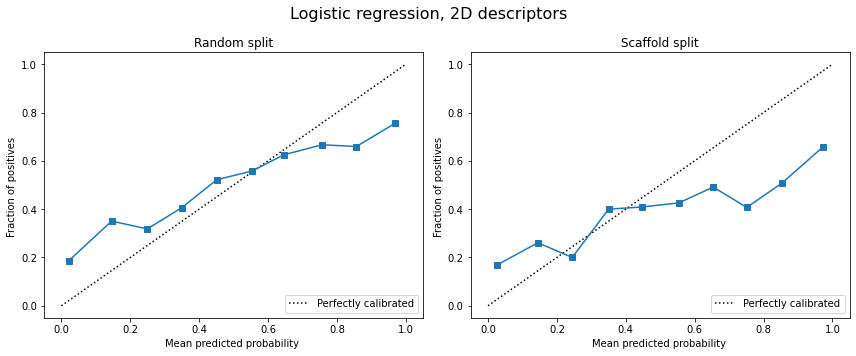

In [69]:
# Logistic regression, 2D descriptors

# Random split
plot1 = output_calibration_display(LogisticRegression(solver='liblinear', random_state=0), "descs",
                                   X_train_random, y_train_random, X_test_random, y_test_random)

# Scaffold split
plot2 = output_calibration_display(LogisticRegression(solver='liblinear', random_state=0), "descs",
                                   X_train_scaffold, y_train_scaffold, X_test_scaffold, y_test_scaffold)

# Plot CalibrationDisplays lado a lado
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Logistic regression, 2D descriptors', fontsize=16)

plot1.plot(ax=axs[0])
axs[0].set_title('Random split')

plot2.plot(ax=axs[1])
axs[1].set_title('Scaffold split')

plt.tight_layout()
plt.show()


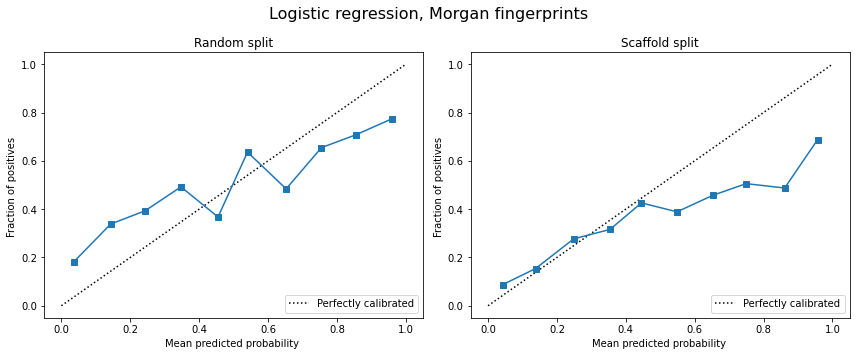

In [55]:
# Logistic regression, Morgan fingerprints

# Random split
plot1 = output_calibration_display(LogisticRegression(random_state=0), "fps",
                                   X_train_random, y_train_random, X_test_random, y_test_random)

# Scaffold split
plot2 = output_calibration_display(LogisticRegression(random_state=0), "fps",
                                   X_train_scaffold, y_train_scaffold, X_test_scaffold, y_test_scaffold)

# Plot CalibrationDisplays lado a lado
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Logistic regression, Morgan fingerprints', fontsize=16)

plot1.plot(ax=axs[0])
axs[0].set_title('Random split')

plot2.plot(ax=axs[1])
axs[1].set_title('Scaffold split')

plt.tight_layout()
plt.show()

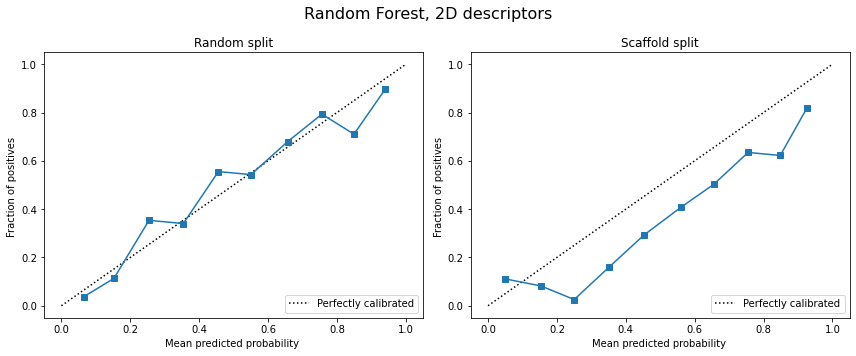

In [70]:
# Random Forest, 2D descriptors

# Random split
plot1 = output_calibration_display(RandomForestClassifier(random_state=0), "descs",
                                   X_train_random, y_train_random, X_test_random, y_test_random)

# Scaffold split
plot2 = output_calibration_display(RandomForestClassifier(random_state=0), "descs",
                                   X_train_scaffold, y_train_scaffold, X_test_scaffold, y_test_scaffold)

# Plot CalibrationDisplays lado a lado
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Random Forest, 2D descriptors', fontsize=16)

plot1.plot(ax=axs[0])
axs[0].set_title('Random split')

plot2.plot(ax=axs[1])
axs[1].set_title('Scaffold split')

plt.tight_layout()
plt.show()


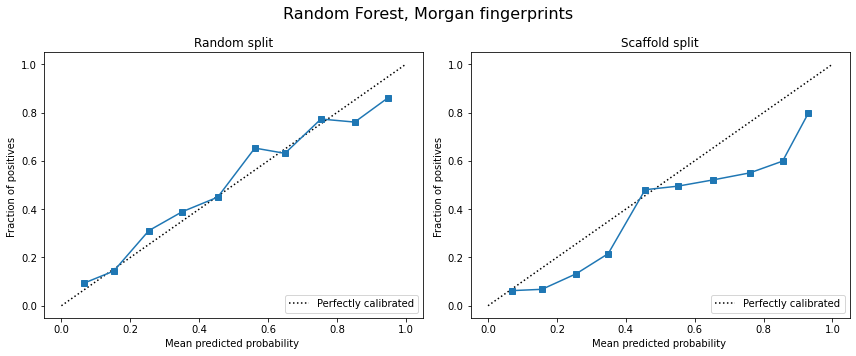

In [57]:
# Random Forest, Morgan fingerprints

# Random split
plot1 = output_calibration_display(RandomForestClassifier(random_state=0), "fps",
                                   X_train_random, y_train_random, X_test_random, y_test_random)

# Scaffold split
plot2 = output_calibration_display(RandomForestClassifier(random_state=0), "fps",
                                   X_train_scaffold, y_train_scaffold, X_test_scaffold, y_test_scaffold)

# Plot CalibrationDisplays lado a lado
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Random Forest, Morgan fingerprints', fontsize=16)

plot1.plot(ax=axs[0])
axs[0].set_title('Random split')

plot2.plot(ax=axs[1])
axs[1].set_title('Scaffold split')

plt.tight_layout()
plt.show()


Essa análise foi baseada no trabalho [Real-World Molecular Out-Of-Distribution: Specification and Investigation](https://chemrxiv.org/engage/chemrxiv/article-details/64c012a1b053dad33ae21932), que chamaremos de MOOD.

Nossos resultados indicam que a combinação *Random forest* + *random split* produz os modelos mais bem calibrados. 

Os Morgan *fingerprints* parecem gerar modelos um pouco mais robustos para o *scaffold split*, mas isso não é tão claro. No MOOD, foi observado que os descritores 2D, e WHIM, um método 3D, são os mais robustos e apresentam melhor capacidade de generalização do que os *fingerprints*.

O *scaffold split*, apesar de gerar predições mais adequadas para aplicações reais dos modelos, demonstra uma menor confiabilidade. Isso também foi observado no MOOD.

Finalmente, no MOOD foi observado que a calibração tende a degradar para compostos mais distantes do conjunto de treinamento. Dessa forma, é importante definir o domínio de aplicabilidade dos modelos (e remover os compostos fora dele) antes de fazer as curvas de calibração. Pode ser interessante separar o conjunto de teste em dois: compostos mais próximos e os mais distantes, e comparar as duas curvas.

## Destruindo a calibração de modelos

Métodos comumente usados para lidar com dados desbalanceados, como *oversampling* (SMOTE) ou o ajuste dos pesos das classes, impactam negativamente a calibração dos modelos. 

Vejamos um exemplo a seguir, em que treinamos três modelos com diferentes estratégias:

In [72]:
%%capture
!pip install imbalanced-learn

In [122]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from imblearn.over_sampling import SMOTE

# Criando um dataset desbalanceado
X, y = make_classification(n_samples=2000, n_features=20, n_informative=15, n_redundant=5,
                           weights=[0.8], flip_y=0, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=0)

# 1. Treinar modelo sem levar em conta o desbalanceamento

clf_1 = LogisticRegression(random_state=0)
clf_1.fit(X_train, y_train)

# Predições
y_pred_1 = clf_1.predict(X_test)
y_pred_proba_1 = clf_1.predict_proba(X_test)[:, 1]

# Métricas
print(f"Acurácia - modelo baseline: {accuracy_score(y_test, y_pred_1):.3f}")
print(f"F1-score - modelo baseline: {f1_score(y_test, y_pred_1):.3f}")
print(f"ROC/AUC  - modelo baseline: {roc_auc_score(y_test, y_pred_proba_1):.3f}")

# 2. Treinar modelo levando em conta o desbalanceamento usandp class_weight='balanced'

clf_2 = LogisticRegression(class_weight='balanced', random_state=0)
clf_2.fit(X_train, y_train)

# Predições
y_pred_2 = clf_2.predict(X_test)
y_pred_proba_2 = clf_2.predict_proba(X_test)[:, 1]

# Métricas
print(f"Acurácia com class_weight='balanced': {accuracy_score(y_test, y_pred_2):.3f}")
print(f"F1-score com class_weight='balanced': {f1_score(y_test, y_pred_2):.3f}")
print(f"ROC/AUC  com class_weight='balanced': {roc_auc_score(y_test, y_pred_proba_2):.3f}")

# 3. Treinar modelo levando em conta o desbalanceamento usando SMOTE

smote = SMOTE(random_state=0)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
clf_3 = LogisticRegression(random_state=0)
clf_3.fit(X_train_smote, y_train_smote)

# Predições
y_pred_3 = clf_3.predict(X_test)
y_pred_proba_3 = clf_3.predict_proba(X_test)[:, 1]

# Métricas
print(f"Acurácia com SMOTE: {accuracy_score(y_test, y_pred_3):.3f}", )
print(f"F1-score com SMOTE: {f1_score(y_test, y_pred_3):.3f}")
print(f"ROC/AUC  com SMOTE: {roc_auc_score(y_test, y_pred_proba_3):.3f}")

Acurácia - modelo baseline: 0.818
F1-score - modelo baseline: 0.404
ROC/AUC  - modelo baseline: 0.820
Acurácia com class_weight='balanced': 0.742
F1-score com class_weight='balanced': 0.540
ROC/AUC  com class_weight='balanced': 0.826
Acurácia com SMOTE: 0.752
F1-score com SMOTE: 0.550
ROC/AUC  com SMOTE: 0.825


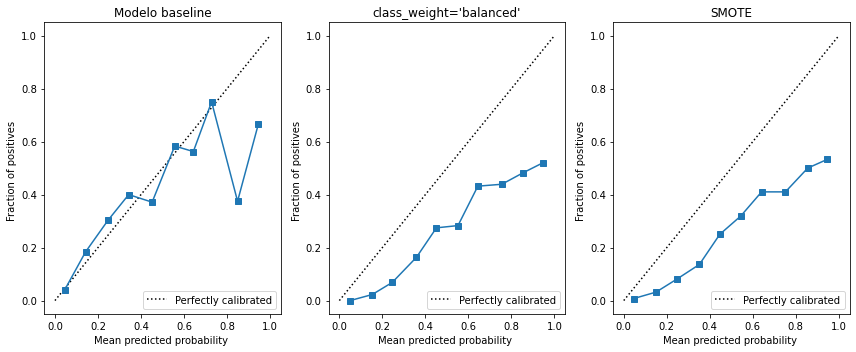

In [123]:
# Diagramas de calibração

prob_true1, prob_pred1 = calibration_curve(y_test, y_pred_proba_1, n_bins=10)
plot1 = CalibrationDisplay(prob_true1, prob_pred1, y_pred_proba_1)

prob_true2, prob_pred2 = calibration_curve(y_test, y_pred_proba_2, n_bins=10)
plot2 = CalibrationDisplay(prob_true2, prob_pred2, y_pred_proba_2)

prob_true3, prob_pred3 = calibration_curve(y_test, y_pred_proba_3, n_bins=10)
plot3 = CalibrationDisplay(prob_true3, prob_pred3, y_pred_proba_3)

# Plot CalibrationDisplays lado a lado
fig, axs = plt.subplots(1, 3, figsize=(12, 5))

plot1.plot(ax=axs[0])
axs[0].set_title('Modelo baseline')

plot2.plot(ax=axs[1])
axs[1].set_title("class_weight='balanced'")

plot3.plot(ax=axs[2])
axs[2].set_title('SMOTE')

plt.tight_layout()
plt.show()

Veja que o uso de métodos para lidar com o desbalanceamento melhora métricas de qualidade como F1-score (a acurácia do modelo *baseline* é maior justamente devido ao desbalanceamento), mas não tem nenhum efeito na capacidade do classificador de discriminar as classes (todos têm o mesmo AUC) e destrói completamente a calibração. 

Por esses motivos, diversas fontes contra-indicam o uso de métodos de *oversampling*. Em vez disso, é recomendável treinar o modelo normalmente e, se necessário, ajustar o *threshold* de classificação para obter melhores métricas. Como exemplo, veja [GHOST: Adjusting the Decision Threshold to Handle Imbalanced Data in Machine Learning](https://pubs.acs.org/doi/full/10.1021/acs.jcim.1c00160) e [Should I balance class weights on logistic regression?](https://pastorjordi.github.io/blog/2022/balance_weights_logreg/)